In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [43]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
# Initial scaling of weights not necessary due to batch normalization, but included anyway
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [44]:
# same optimization as last time
max_steps = 200_000
batch_size = 128
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1  # + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3090
  10000/ 200000: 2.1846
  20000/ 200000: 2.2264
  30000/ 200000: 1.9174
  40000/ 200000: 2.0573
  50000/ 200000: 2.1347
  60000/ 200000: 2.1233
  70000/ 200000: 2.1515
  80000/ 200000: 2.0399
  90000/ 200000: 2.0787
 100000/ 200000: 1.8586
 110000/ 200000: 2.1309
 120000/ 200000: 1.9954
 130000/ 200000: 1.9601
 140000/ 200000: 2.0889
 150000/ 200000: 2.1079
 160000/ 200000: 2.0687
 170000/ 200000: 2.1108
 180000/ 200000: 1.9788
 190000/ 200000: 1.8889


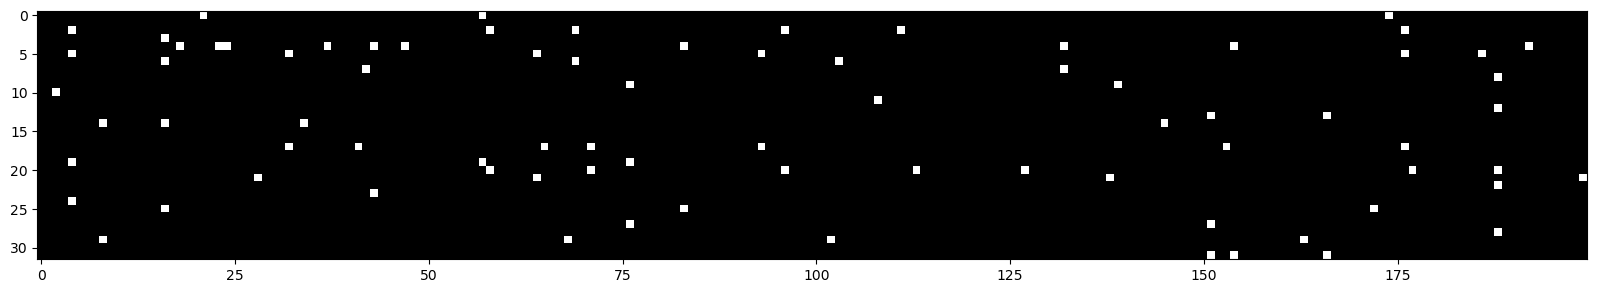

In [39]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

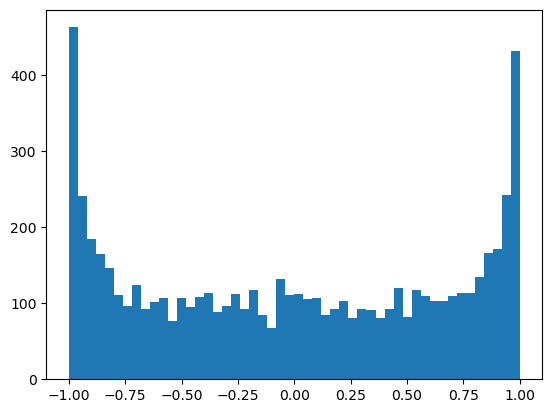

In [13]:
plt.hist(h.view(-1).tolist(), 50)

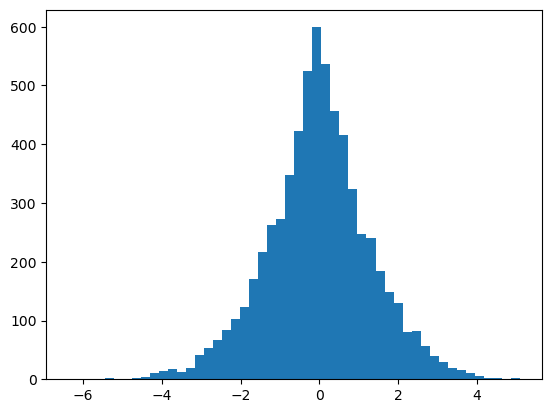

In [14]:
plt.hist(hpreact.view(-1).tolist(), 50)

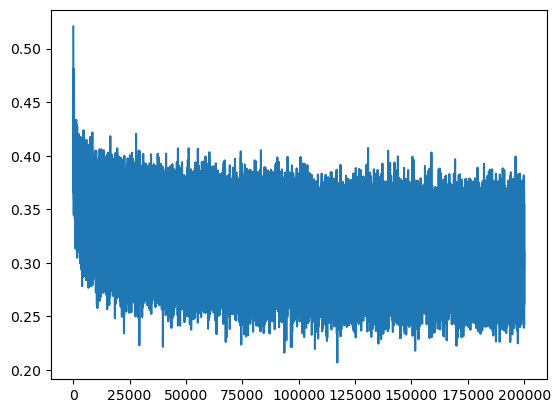

In [20]:
plt.plot(lossi)

In [40]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [45]:
bnstd

tensor([[1.9119, 1.5621, 1.8561, 1.8470, 1.9447, 1.8021, 1.7027, 1.8095, 1.9457,
         1.8821, 1.8874, 1.7569, 1.5290, 2.0150, 1.6481, 1.9574, 2.0860, 1.4599,
         1.9331, 1.9479, 1.8859, 2.1321, 1.6393, 1.8801, 1.5948, 1.7481, 1.7132,
         2.0266, 2.1163, 1.9600, 1.5941, 1.5183, 2.1080, 1.5659, 1.8722, 1.8063,
         2.0830, 1.9545, 1.7523, 1.7665, 1.7074, 1.8033, 1.9309, 1.7687, 1.7830,
         1.7992, 1.9225, 2.1487, 1.6844, 1.7536, 1.6668, 1.6694, 1.8049, 1.7294,
         1.8882, 1.9061, 1.8056, 1.8248, 2.4466, 1.7057, 1.8206, 1.7014, 1.6159,
         1.7405, 1.9091, 1.7553, 1.6869, 1.7488, 1.8284, 1.8359, 1.7665, 1.8025,
         1.5057, 1.6327, 1.4623, 1.3735, 2.1240, 1.8135, 1.5757, 1.7758, 1.7353,
         1.5789, 1.7403, 1.8869, 2.1374, 1.8635, 1.7580, 1.9134, 1.7263, 1.9928,
         1.8029, 1.6004, 1.7961, 1.7399, 1.8466, 1.7814, 1.7835, 1.8699, 1.6183,
         2.0170, 2.1665, 1.7794, 2.1284, 1.7096, 1.5529, 1.8169, 1.6829, 1.8059,
         1.7144, 1.8682, 1.8

In [46]:
bnstd_running

tensor([[1.9086, 1.5540, 1.8535, 1.8416, 1.9469, 1.8002, 1.6979, 1.8022, 1.9480,
         1.8833, 1.8829, 1.7496, 1.5252, 2.0069, 1.6451, 1.9466, 2.0823, 1.4543,
         1.9229, 1.9495, 1.8733, 2.1186, 1.6357, 1.8745, 1.5903, 1.7461, 1.7091,
         2.0185, 2.1036, 1.9555, 1.5889, 1.5132, 2.1063, 1.5637, 1.8665, 1.8049,
         2.0840, 1.9516, 1.7470, 1.7609, 1.7063, 1.7987, 1.9243, 1.7654, 1.7745,
         1.7973, 1.9227, 2.1420, 1.6823, 1.7479, 1.6604, 1.6608, 1.8009, 1.7240,
         1.8854, 1.8979, 1.7976, 1.8229, 2.4490, 1.6994, 1.8126, 1.6961, 1.6133,
         1.7368, 1.9050, 1.7513, 1.6795, 1.7459, 1.8232, 1.8318, 1.7609, 1.7993,
         1.5047, 1.6278, 1.4572, 1.3612, 2.1204, 1.8106, 1.5735, 1.7696, 1.7309,
         1.5745, 1.7361, 1.8746, 2.1325, 1.8559, 1.7572, 1.9104, 1.7248, 1.9879,
         1.7976, 1.5923, 1.7915, 1.7396, 1.8418, 1.7804, 1.7810, 1.8646, 1.6146,
         2.0130, 2.1633, 1.7756, 2.1193, 1.7063, 1.5436, 1.8152, 1.6743, 1.8048,
         1.7078, 1.8608, 1.8

In [47]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "val": (Xdev, Ydev), "test": (Xte, Yte)}[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, bloc_size * n_embd)
    hpreact = embcat @ W1  # + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # calculating mean and std at test time
    # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0308592319488525
val 2.092557668685913


In [48]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, bloc_size, n_embd)
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

mona.
kayah.
see.
medhayla.
rethruthadrie.
cadelyn.
elin.
shi.
jenleigh.
estana.
selyn.
malaia.
nosalbergihira.
sten.
joselynn.
noelianuel.
geder.
yarue.
els.
kayshuston.


In [30]:
# PyTorch-ifying

from typing import Any


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameter in total
for p in parameters:
    p.requires_grad = True

47551


In [31]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters]
        )

    if i > 1000:
        break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean +0f, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0f, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean +0f, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0f, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean +0f, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

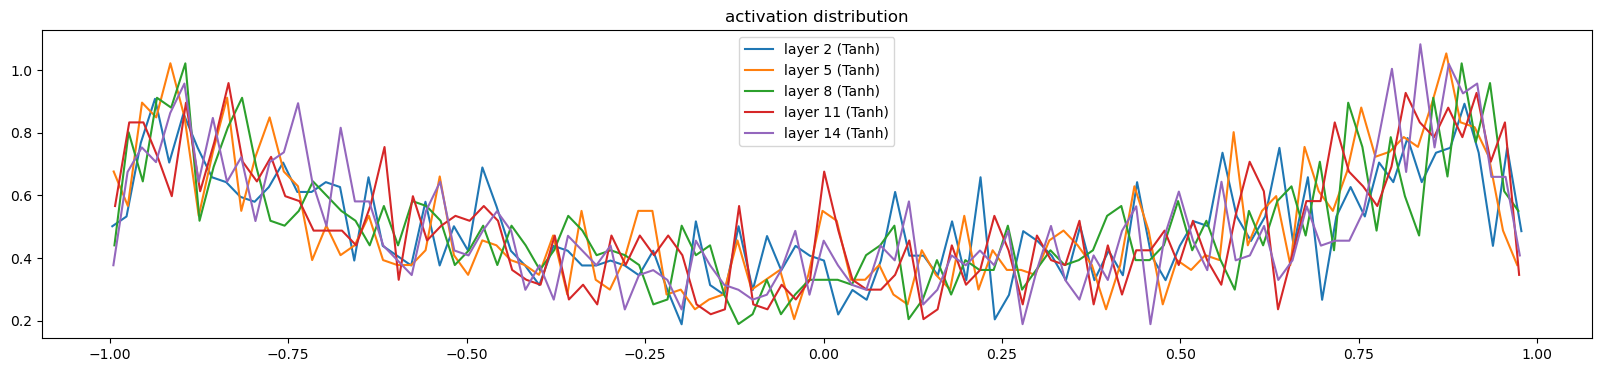

In [32]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.df, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean +0f, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0f, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0f, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0f, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0f, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

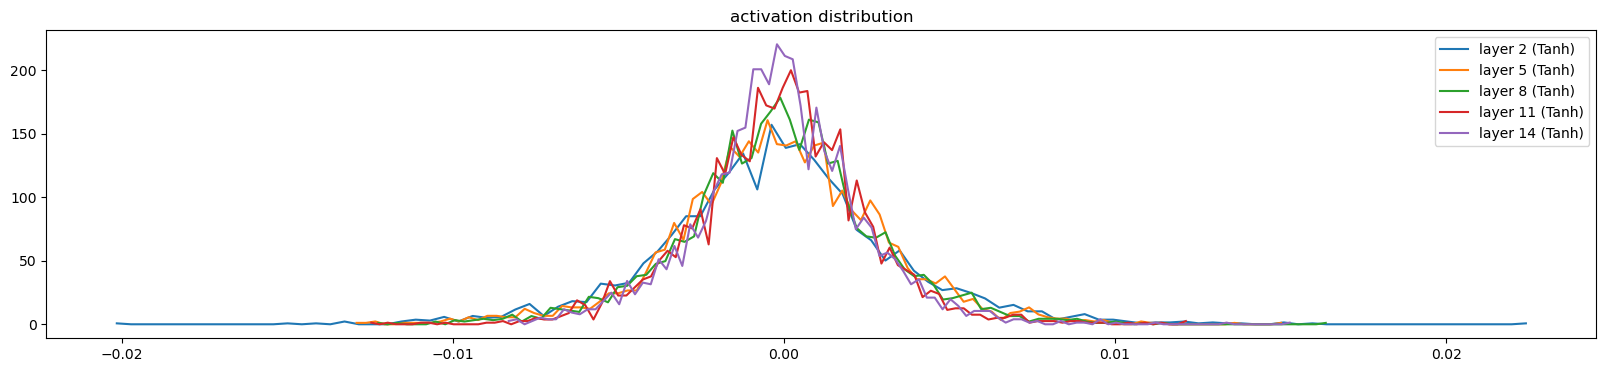

In [37]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+.df, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

weight   (27, 10) | mean +0.000543 | std 1.210879e-02 | grad:data ratio 1.210872e-02
weight  (30, 100) | mean +0.000091 | std 8.572473e-03 | grad:data ratio 2.741173e-02
weight (100, 100) | mean -0.000079 | std 6.680249e-03 | grad:data ratio 3.974532e-02
weight (100, 100) | mean -0.000033 | std 6.521374e-03 | grad:data ratio 3.846635e-02
weight (100, 100) | mean +0.000037 | std 6.064260e-03 | grad:data ratio 3.592852e-02
weight (100, 100) | mean -0.000092 | std 5.176418e-03 | grad:data ratio 3.075116e-02
weight  (100, 27) | mean +0.000000 | std 2.309357e-02 | grad:data ratio 3.261764e-01


Text(0.5, 1.0, 'weights gradient distribution')

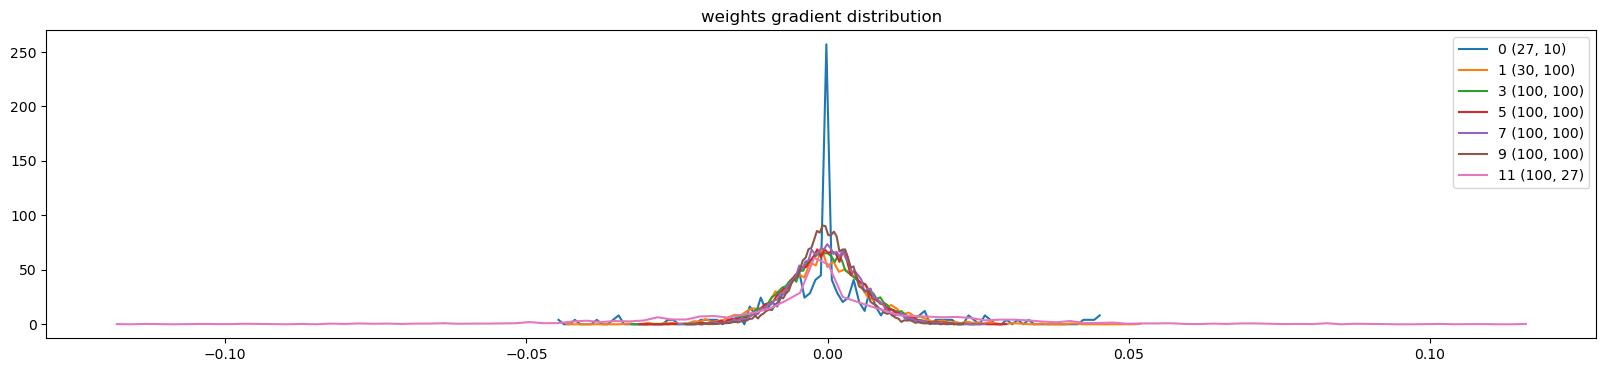

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")

plt.legend(legends)
plt.title("weights gradient distribution")

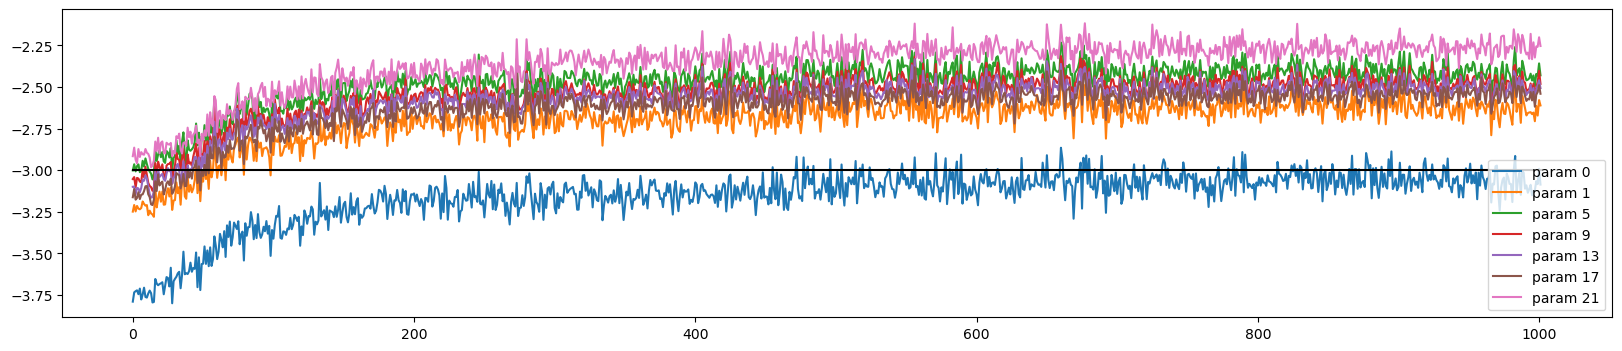

In [36]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)